# March Madness 2025 Prediction Model

## By Logan Laszewski

### Packages

In [1]:
!pip install xgboost
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from collections import Counter

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint

from sklearn.preprocessing import MinMaxScaler
import pandas as pd


### Data Sets from Kaggle - March Madness Learning Mania

In [2]:
m_TourneySeeds = pd.read_csv("MNCAATourneySeeds.csv")
m_Teams = pd.read_csv("MTeams.csv")
#m_RegCompact = pd.read_csv("MRegularSeasonCompactResults.csv")
m_RegDetailed = pd.read_csv("MRegularSeasonDetailedResults.csv")
#submission_df = pd.read_csv("SampleSubmissionStage1.csv")
m_Seasons = pd.read_csv("MSeasons.csv")
m_Conferences  = pd.read_csv("MTeamConferences.csv")
m_TourneyCompact = pd.read_csv("MNCAATourneyCompactResults.csv")
#m_Massey = pd.read_csv("MMasseyOrdinals.csv")

In [3]:
m_Teams.head(3)

,TeamID,TeamName,FirstD1Season,LastD1Season
0,1101,Abilene Chr,2014,2025
1,1102,Air Force,1985,2025
2,1103,Akron,1985,2025


In [4]:
AllUniqueTeams = m_Teams["TeamID"].unique()
len(AllUniqueTeams)

380

### Statistics to use from regular season

In [5]:
#take stats for all of my unique teams
#grab where the unique team (currently on, will iterate through), was either WTeamID) or the losing team (LTeamID)

#create new column called win (1 for win, 0 for loss)
#groups the data by season to get season stats

In [6]:
m_RegDetailed.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,WFGM,WFGA,...,LFGA3,LFTM,LFTA,LOR,LDR,LAst,LTO,LStl,LBlk,LPF
0,2003,10,1104,68,1328,62,N,0,27,58,...,10,16,22,10,22,8,18,9,2,20
1,2003,10,1272,70,1393,63,N,0,26,62,...,24,9,20,20,25,7,12,8,6,16
2,2003,11,1266,73,1437,61,N,0,24,58,...,26,14,23,31,22,9,12,2,5,23


In [7]:
m_RegDetailed.columns

Index(['Season', 'DayNum', 'WTeamID', 'WScore', 'LTeamID', 'LScore', 'WLoc',
       'NumOT', 'WFGM', 'WFGA', 'WFGM3', 'WFGA3', 'WFTM', 'WFTA', 'WOR', 'WDR',
       'WAst', 'WTO', 'WStl', 'WBlk', 'WPF', 'LFGM', 'LFGA', 'LFGM3', 'LFGA3',
       'LFTM', 'LFTA', 'LOR', 'LDR', 'LAst', 'LTO', 'LStl', 'LBlk', 'LPF'],
      dtype='object')

In [8]:
# 1. Get all TeamIDs that appear in the regular season detailed results
teams_with_games = set(m_RegDetailed['WTeamID']).union(set(m_RegDetailed['LTeamID']))

# 2. Get all unique team IDs from the teams file
all_known_teams = set(m_Teams['TeamID'])

# 3. Find teams that are in your list but have no games
teams_without_stats = all_known_teams - teams_with_games

# 4. Print count and optionally view them
print(f"Teams with no regular season games: {len(teams_without_stats)}")

# Optional: print names of teams without games
missing_team_names = m_Teams[m_Teams['TeamID'].isin(teams_without_stats)]
print(missing_team_names[['TeamID', 'TeamName']])

Teams with no regular season games: 9
     TeamID        TeamName
8      1109    Alliant Intl
17     1118    Armstrong St
20     1121         Augusta
33     1134        Brooklyn
114    1215  Hardin-Simmons
201    1302     NE Illinois
226    1327       Okla City
331    1432           Utica
345    1446     W Texas A&M


### A loop that takes all TeamIDs and gets yearly stats for each team. I pick which features I think will be helpful in order to determine winner of game

### Each stat is a sum of every game in that season. Along with looking at the stats their opponents put up against them

In [9]:
# Initialize a list to store results for each team
team_season_stats = []

for team in AllUniqueTeams:
    # Filter for the specific team
    m_team = m_RegDetailed[
        (m_RegDetailed['WTeamID'] == team) | (m_RegDetailed['LTeamID'] == team)
    ].copy()
    
    if m_team.empty:
        print(f"Skipping team {team} — no games played.")
        continue

    # Create Win column
    m_team['Win'] = (m_team['WTeamID'] == team).astype(int)

    # Calculate necessary columns before grouping
    m_team['three_point_att_for'] = m_team.apply(lambda x: x['WFGA3'] if x['Win'] == 1 else x['LFGA3'], axis=1)
    m_team['three_point_made_for'] = m_team.apply(lambda x: x['WFGM3'] if x['Win'] == 1 else x['LFGM3'], axis=1)
    m_team['points_for'] = m_team.apply(lambda x: x['WScore'] if x['Win'] == 1 else x['LScore'], axis=1)
    m_team['points_against'] = m_team.apply(lambda x: x['LScore'] if x['Win'] == 1 else x['WScore'], axis=1)

    m_team['WTO'] = m_team.apply(lambda x: x['WTO'] if x['Win'] == 1 else x['LTO'], axis=1)
    m_team['LTO'] = m_team.apply(lambda x: x['LTO'] if x['Win'] == 1 else x['WTO'], axis=1)
    m_team['offensive_rebounds'] = m_team.apply(lambda x: x['WOR'] if x['Win'] == 1 else x['LOR'], axis=1)
    m_team['opponent_offensive_rebounds'] = m_team.apply(lambda x: x['LOR'] if x['Win'] == 1 else x['WOR'], axis=1)
    m_team['personal_fouls'] = m_team.apply(lambda x: x['WPF'] if x['Win'] == 1 else x['LPF'], axis=1)
    m_team['opponent_personal_fouls'] = m_team.apply(lambda x: x['LPF'] if x['Win'] == 1 else x['WPF'], axis=1)
    m_team['three_point_att_against'] = m_team.apply(lambda x: x['LFGA3'] if x['Win'] == 1 else x['WFGA3'], axis=1)
    m_team['three_point_made_against'] = m_team.apply(lambda x: x['LFGM3'] if x['Win'] == 1 else x['WFGM3'], axis=1)
    m_team['field_goal_att_for'] = m_team.apply(lambda x: x['WFGA'] if x['Win'] == 1 else x['LFGA'], axis=1)
    m_team['field_goal_att_against'] = m_team.apply(lambda x: x['LFGA'] if x['Win'] == 1 else x['WFGA'], axis=1)
    m_team['free_throw_att_for'] = m_team.apply(lambda x: x['WFTA'] if x['Win'] == 1 else x['LFTA'], axis=1)
    m_team['free_throw_att_against'] = m_team.apply(lambda x: x['LFTA'] if x['Win'] == 1 else x['WFTA'], axis=1)
    m_team['field_goals_made_for'] = m_team.apply(lambda x: x['WFGM'] if x['Win'] == 1 else x['LFGM'], axis=1)
    m_team['field_goals_made_against'] = m_team.apply(lambda x: x['LFGM'] if x['Win'] == 1 else x['WFGM'], axis=1)
    m_team['stl_for'] = m_team.apply(lambda x: x['WStl'] if x['Win'] == 1 else x['LStl'], axis=1)
    m_team['stl_against'] = m_team.apply(lambda x: x['LStl'] if x['Win'] == 1 else x['WStl'], axis=1)
    m_team['blk_for'] = m_team.apply(lambda x: x['WBlk'] if x['Win'] == 1 else x['LBlk'], axis=1)
    m_team['blk_against'] = m_team.apply(lambda x: x['LBlk'] if x['Win'] == 1 else x['WBlk'], axis=1)
    m_team['ast_for'] = m_team.apply(lambda x: x['WAst'] if x['Win'] == 1 else x['LAst'], axis=1)
    m_team['ast_against'] = m_team.apply(lambda x: x['LAst'] if x['Win'] == 1 else x['WAst'], axis=1)
    m_team['dr_for'] = m_team.apply(lambda x: x['WDR'] if x['Win'] == 1 else x['LDR'], axis=1)
    m_team['dr_against'] = m_team.apply(lambda x: x['LDR'] if x['Win'] == 1 else x['WDR'], axis=1)

    # Group by season and aggregate
    grouped_team = m_team.groupby('Season').agg(
        win_sum=('Win', 'sum'),
        loss_sum=('Win', lambda x: (x == 0).sum()),
        three_point_att_for=('three_point_att_for', 'sum'),
        three_point_made_for=('three_point_made_for', 'sum'),
        points_for=('points_for', 'sum'),
        points_against=('points_against', 'sum'),

        TO_for=('WTO', 'sum'),  # Summing the turnovers for the winning team
        TO_against=('LTO', 'sum'),
        offensive_rebounds_for=('offensive_rebounds', 'sum'),
        offensive_rebounds_against=('opponent_offensive_rebounds', 'sum'),
        personal_fouls_for=('personal_fouls', 'sum'),  # Sum of personal fouls for the winning team
        personal_fouls_against=('opponent_personal_fouls', 'sum') ,
        three_point_att_against=('three_point_att_against', 'sum'),
        three_point_made_against=('three_point_made_against', 'sum'),
        field_goal_att_for=('field_goal_att_for', 'sum'),
        field_goal_att_against=('field_goal_att_against', 'sum'),
        free_throw_att_for=('free_throw_att_for', 'sum'),
        free_throw_att_against=('free_throw_att_against', 'sum'),
        field_goals_made_for=('field_goals_made_for', 'sum'),
        field_goals_made_against=('field_goals_made_against', 'sum'),
        stl_for=('stl_for', 'sum'),
        stl_against=('stl_against', 'sum'),
        blk_for=('blk_for', 'sum'),
        blk_against=('blk_against', 'sum'),
        ast_for=('ast_for', 'sum'),
        ast_against=('ast_against', 'sum'),
        dr_for=('dr_for', 'sum'),
        dr_against=('dr_against', 'sum')

    ).reset_index()

    # Add TeamID
    grouped_team['TeamID'] = team

    # Merge with seeds and conferences
    grouped_team = pd.merge(grouped_team, m_TourneySeeds, on=['Season', 'TeamID'], how='left')
    grouped_team = pd.merge(grouped_team, m_Conferences, on=['Season', 'TeamID'], how='left')

    team_season_stats.append(grouped_team)

# Combine all results
final_team_stats = pd.concat(team_season_stats, ignore_index=True)

Skipping team 1109 — no games played.
Skipping team 1118 — no games played.
Skipping team 1121 — no games played.
Skipping team 1134 — no games played.
Skipping team 1215 — no games played.
Skipping team 1302 — no games played.
Skipping team 1327 — no games played.
Skipping team 1432 — no games played.
Skipping team 1446 — no games played.


In [10]:
final_team_stats.head(3)

,Season,win_sum,loss_sum,three_point_att_for,three_point_made_for,points_for,points_against,TO_for,TO_against,offensive_rebounds_for,...,stl_against,blk_for,blk_against,ast_for,ast_against,dr_for,dr_against,TeamID,Seed,ConfAbbrev
0,2014,2,19,375,140,1326,1651,315,316,168,...,147,31,105,210,327,427,506,1101,NaN,southland
1,2015,7,21,537,203,1708,2012,359,372,231,...,164,33,119,332,362,550,725,1101,NaN,southland
2,2016,9,18,509,185,1886,2059,362,382,221,...,138,66,89,348,347,608,681,1101,NaN,southland


# Add additional Statistics

### Add a column that shows games played for that team on given year

In [11]:
final_team_stats["games_played"] = final_team_stats["win_sum"] + final_team_stats["loss_sum"]
final_team_stats.head(3)

,Season,win_sum,loss_sum,three_point_att_for,three_point_made_for,points_for,points_against,TO_for,TO_against,offensive_rebounds_for,...,blk_for,blk_against,ast_for,ast_against,dr_for,dr_against,TeamID,Seed,ConfAbbrev,games_played
0,2014,2,19,375,140,1326,1651,315,316,168,...,31,105,210,327,427,506,1101,NaN,southland,21
1,2015,7,21,537,203,1708,2012,359,372,231,...,33,119,332,362,550,725,1101,NaN,southland,28
2,2016,9,18,509,185,1886,2059,362,382,221,...,66,89,348,347,608,681,1101,NaN,southland,27


### Add a column to get 3 point percentage for team and opponent

In [12]:
final_team_stats['three_point_percentage_for'] = (final_team_stats['three_point_made_for'] / final_team_stats['three_point_att_for']) * 100
final_team_stats['three_point_percentage_against'] = (final_team_stats['three_point_made_against'] / final_team_stats['three_point_att_against']) * 100

#final_team_stats.drop(columns=['three_point_att_for', 'three_point_made_for', 'three_point_att_against', 'three_point_made_against'], inplace=True)
#final_team_stats.head(5)

### Add a column to point differential for teams

In [13]:
final_team_stats["Point Differential"] = (final_team_stats["points_for"] - final_team_stats["points_against"])
final_team_stats.head(3)

,Season,win_sum,loss_sum,three_point_att_for,three_point_made_for,points_for,points_against,TO_for,TO_against,offensive_rebounds_for,...,ast_against,dr_for,dr_against,TeamID,Seed,ConfAbbrev,games_played,three_point_percentage_for,three_point_percentage_against,Point Differential
0,2014,2,19,375,140,1326,1651,315,316,168,...,327,427,506,1101,NaN,southland,21,37.333333,37.058824,-325
1,2015,7,21,537,203,1708,2012,359,372,231,...,362,550,725,1101,NaN,southland,28,37.802607,36.965812,-304
2,2016,9,18,509,185,1886,2059,362,382,221,...,347,608,681,1101,NaN,southland,27,36.345776,36.919315,-173


### Add a column to get eFG% (FGM + 0.5 * 3PM) / FGA

In [14]:
final_team_stats['efg_percentage_for'] = (final_team_stats['field_goals_made_for'] + 0.5 * final_team_stats['three_point_made_for']) / final_team_stats['field_goal_att_for']
final_team_stats['efg_percentage_against'] = (final_team_stats['field_goals_made_against'] + 0.5 * final_team_stats['three_point_made_against']) / final_team_stats['field_goal_att_against']
final_team_stats.head(3)

,Season,win_sum,loss_sum,three_point_att_for,three_point_made_for,points_for,points_against,TO_for,TO_against,offensive_rebounds_for,...,dr_against,TeamID,Seed,ConfAbbrev,games_played,three_point_percentage_for,three_point_percentage_against,Point Differential,efg_percentage_for,efg_percentage_against
0,2014,2,19,375,140,1326,1651,315,316,168,...,506,1101,NaN,southland,21,37.333333,37.058824,-325,0.471985,0.564171
1,2015,7,21,537,203,1708,2012,359,372,231,...,725,1101,NaN,southland,28,37.802607,36.965812,-304,0.473347,0.553020
2,2016,9,18,509,185,1886,2059,362,382,221,...,681,1101,NaN,southland,27,36.345776,36.919315,-173,0.505151,0.545549


### Add a column to get FT attempts / FGA (Free throw rate)

In [15]:
#WGA and #WFTA
#LGA and #LFTA
final_team_stats['free_throw_rate_for'] = (final_team_stats['free_throw_att_for'] / final_team_stats['field_goal_att_for']) * 100
final_team_stats['free_throw_rate_against'] = (final_team_stats['free_throw_att_against'] / final_team_stats['field_goal_att_against']) * 100
final_team_stats.head(3)

,Season,win_sum,loss_sum,three_point_att_for,three_point_made_for,points_for,points_against,TO_for,TO_against,offensive_rebounds_for,...,Seed,ConfAbbrev,games_played,three_point_percentage_for,three_point_percentage_against,Point Differential,efg_percentage_for,efg_percentage_against,free_throw_rate_for,free_throw_rate_against
0,2014,2,19,375,140,1326,1651,315,316,168,...,NaN,southland,21,37.333333,37.058824,-325,0.471985,0.564171,42.260209,48.306595
1,2015,7,21,537,203,1708,2012,359,372,231,...,NaN,southland,28,37.802607,36.965812,-304,0.473347,0.553020,28.272605,44.662921
2,2016,9,18,509,185,1886,2059,362,382,221,...,NaN,southland,27,36.345776,36.919315,-173,0.505151,0.545549,40.315934,46.514838


### Add a column that gets teams ranking towards end of Season (Day 100)

In [16]:
m_Massey = pd.read_csv("MMasseyOrdinals.csv")
m_Massey.head(3)

,Season,RankingDayNum,SystemName,TeamID,OrdinalRank
0,2003,35,SEL,1102,159
1,2003,35,SEL,1103,229
2,2003,35,SEL,1104,12


In [17]:
m_Massey_filtered = m_Massey[
    (m_Massey['RankingDayNum'] == 100) & 
    (m_Massey['SystemName'] == 'POM')]

In [18]:
final_team_stats = pd.merge(
    final_team_stats,
    m_Massey_filtered[['Season', 'TeamID', 'OrdinalRank']],
    on=['Season', 'TeamID'],
    how='left')

In [19]:
final_team_stats.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7981 entries, 0 to 7980
Data columns (total 41 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Season                          7981 non-null   int64  
 1   win_sum                         7981 non-null   int64  
 2   loss_sum                        7981 non-null   int64  
 3   three_point_att_for             7981 non-null   int64  
 4   three_point_made_for            7981 non-null   int64  
 5   points_for                      7981 non-null   int64  
 6   points_against                  7981 non-null   int64  
 7   TO_for                          7981 non-null   int64  
 8   TO_against                      7981 non-null   int64  
 9   offensive_rebounds_for          7981 non-null   int64  
 10  offensive_rebounds_against      7981 non-null   int64  
 11  personal_fouls_for              7981 non-null   int64  
 12  personal_fouls_against          79

### Add a column for Possessions/Pace of Play

In [20]:
# Possessions for
final_team_stats['possessions_for'] = (
    final_team_stats['field_goal_att_for'] +
    0.44 * final_team_stats['free_throw_att_for'] -
    final_team_stats['offensive_rebounds_for'] +
    final_team_stats['TO_for'])

# Possessions against
final_team_stats['possessions_against'] = (
    final_team_stats['field_goal_att_against'] +
    0.44 * final_team_stats['free_throw_att_against'] -
    final_team_stats['offensive_rebounds_against'] +
    final_team_stats['TO_against'])

### Now, divide all of the stats by games played. So I can get a game average for each season, since games played has a little bit of fluctuation (based on data that was able to be collected from kaggle)

In [21]:
stat_columns = [
    'three_point_att_for', 'three_point_made_for', 'points_for', 'points_against',
    'TO_for', 'TO_against', 'offensive_rebounds_for', 'offensive_rebounds_against',
    'personal_fouls_for', 'personal_fouls_against', 'Point Differential', 'field_goal_att_against' , 'field_goal_att_for',
    'free_throw_att_for','free_throw_att_against','three_point_att_against', 'three_point_made_against',
    'field_goals_made_for', 'field_goals_made_against',  'stl_for', 'stl_against', 'blk_for', 'blk_against',
    'ast_for', 'ast_against', 'dr_for', 'dr_against', 'possessions_for','possessions_against'
]

# Loop through each column and divide by games_played
for col in stat_columns:
    final_team_stats[col + '_avg'] = final_team_stats[col] / final_team_stats['games_played']

# Drop the original columns
final_team_stats.drop(columns=stat_columns, inplace=True)

# Display the updated dataset
final_team_stats.head()

,Season,win_sum,loss_sum,TeamID,Seed,ConfAbbrev,games_played,three_point_percentage_for,three_point_percentage_against,efg_percentage_for,...,stl_for_avg,stl_against_avg,blk_for_avg,blk_against_avg,ast_for_avg,ast_against_avg,dr_for_avg,dr_against_avg,possessions_for_avg,possessions_against_avg
0,2014,2,19,1101,NaN,southland,21,37.333333,37.058824,0.471985,...,5.761905,7.000000,1.476190,5.000000,10.000000,15.571429,20.333333,24.095238,66.466667,69.451429
1,2015,7,21,1101,NaN,southland,28,37.802607,36.965812,0.473347,...,5.928571,5.857143,1.178571,4.250000,11.857143,12.928571,19.642857,25.892857,64.084286,64.101429
2,2016,9,18,1101,NaN,southland,27,36.345776,36.919315,0.505151,...,6.740741,5.111111,2.444444,3.296296,12.888889,12.851852,22.518519,25.222222,68.714074,70.205926
3,2017,9,16,1101,NaN,southland,25,37.106918,36.122449,0.524756,...,7.000000,6.040000,2.760000,3.160000,13.600000,13.600000,22.880000,25.040000,68.406400,67.992000
4,2018,12,15,1101,NaN,southland,27,32.467532,33.583490,0.509180,...,7.148148,6.518519,3.629630,2.925926,13.888889,12.037037,23.222222,25.037037,70.065185,69.834074


In [22]:
final_team_stats.columns

Index(['Season', 'win_sum', 'loss_sum', 'TeamID', 'Seed', 'ConfAbbrev',
       'games_played', 'three_point_percentage_for',
       'three_point_percentage_against', 'efg_percentage_for',
       'efg_percentage_against', 'free_throw_rate_for',
       'free_throw_rate_against', 'OrdinalRank', 'three_point_att_for_avg',
       'three_point_made_for_avg', 'points_for_avg', 'points_against_avg',
       'TO_for_avg', 'TO_against_avg', 'offensive_rebounds_for_avg',
       'offensive_rebounds_against_avg', 'personal_fouls_for_avg',
       'personal_fouls_against_avg', 'Point Differential_avg',
       'field_goal_att_against_avg', 'field_goal_att_for_avg',
       'free_throw_att_for_avg', 'free_throw_att_against_avg',
       'three_point_att_against_avg', 'three_point_made_against_avg',
       'field_goals_made_for_avg', 'field_goals_made_against_avg',
       'stl_for_avg', 'stl_against_avg', 'blk_for_avg', 'blk_against_avg',
       'ast_for_avg', 'ast_against_avg', 'dr_for_avg', 'dr_against_a

In [23]:
final_team_stats["Seed"].value_counts()

Y15     22
Y03     22
Y06     22
X02     22
Y04     22
        ..
X12a     1
Z14a     1
Z10a     1
Z13a     1
Y12b     1
Name: Seed, Length: 94, dtype: int64

### Get Seed of each team without the unnecssary formatting

In [24]:
final_team_stats['Seed'] = final_team_stats['Seed'].str.extract('(\d+)').astype(float)
final_team_stats["Seed"].unique()

array([nan, 15., 14., 11., 13., 12., 10.,  8.,  5.,  9.,  2.,  6.,  1.,
        4., 16.,  3.,  7.])

### Set a conference strength (1-4) So I can use conference in my model

In [25]:
#Make conference strength levels (1-4)

final_team_stats['ConfRank'] = None  # Initialize the ConfRank column

# Map conference abbreviations to strength values
final_team_stats.loc[final_team_stats['ConfAbbrev'].isin(["big_ten", "sec", "acc", "big_twelve",
                                                           "pac_twelve", "pac_ten", "big_east"]), 'ConfRank'] = 1

final_team_stats.loc[final_team_stats['ConfAbbrev'].isin(["aac", "mwc", "mvc", "wcc",
                                                           "a_ten", "cusa"]), 'ConfRank'] = 2

final_team_stats.loc[final_team_stats['ConfAbbrev'].isin(["caa", "aec", "southern", "sun_belt",
                                                           "horizon", "maac", "big_west",
                                                           "mac", "mid_cont", "summit", "big_sky",
                                                           "big_south", "patriot"]), 'ConfRank'] = 3

final_team_stats.loc[final_team_stats['ConfAbbrev'].isin(["wac", "southland", "ovc", "ivy",
                                                           "nec", "meac", "swac", "a_sun",
                                                           "gwc", "ind"]), 'ConfRank'] = 4

In [26]:
#Teams who aren't in tournament, set a seed other than NA
final_team_stats['Seed'].fillna(-1, inplace=True)

In [27]:
# Remove the conference abbreviation, we need all numeric values for xgboost
final_team_stats.drop(columns=['ConfAbbrev'], inplace=True)
final_team_stats.head(5)

,Season,win_sum,loss_sum,TeamID,Seed,games_played,three_point_percentage_for,three_point_percentage_against,efg_percentage_for,efg_percentage_against,...,stl_against_avg,blk_for_avg,blk_against_avg,ast_for_avg,ast_against_avg,dr_for_avg,dr_against_avg,possessions_for_avg,possessions_against_avg,ConfRank
0,2014,2,19,1101,-1.0,21,37.333333,37.058824,0.471985,0.564171,...,7.000000,1.476190,5.000000,10.000000,15.571429,20.333333,24.095238,66.466667,69.451429,4
1,2015,7,21,1101,-1.0,28,37.802607,36.965812,0.473347,0.553020,...,5.857143,1.178571,4.250000,11.857143,12.928571,19.642857,25.892857,64.084286,64.101429,4
2,2016,9,18,1101,-1.0,27,36.345776,36.919315,0.505151,0.545549,...,5.111111,2.444444,3.296296,12.888889,12.851852,22.518519,25.222222,68.714074,70.205926,4
3,2017,9,16,1101,-1.0,25,37.106918,36.122449,0.524756,0.528689,...,6.040000,2.760000,3.160000,13.600000,13.600000,22.880000,25.040000,68.406400,67.992000,4
4,2018,12,15,1101,-1.0,27,32.467532,33.583490,0.509180,0.517394,...,6.518519,3.629630,2.925926,13.888889,12.037037,23.222222,25.037037,70.065185,69.834074,4


### Create all margin stats for team

In [28]:
# for all but Season, TeamID, Seed, games_played, win_sum, loss_sum, Ordinalank, ConfRank

In [29]:
final_team_stats.columns

Index(['Season', 'win_sum', 'loss_sum', 'TeamID', 'Seed', 'games_played',
       'three_point_percentage_for', 'three_point_percentage_against',
       'efg_percentage_for', 'efg_percentage_against', 'free_throw_rate_for',
       'free_throw_rate_against', 'OrdinalRank', 'three_point_att_for_avg',
       'three_point_made_for_avg', 'points_for_avg', 'points_against_avg',
       'TO_for_avg', 'TO_against_avg', 'offensive_rebounds_for_avg',
       'offensive_rebounds_against_avg', 'personal_fouls_for_avg',
       'personal_fouls_against_avg', 'Point Differential_avg',
       'field_goal_att_against_avg', 'field_goal_att_for_avg',
       'free_throw_att_for_avg', 'free_throw_att_against_avg',
       'three_point_att_against_avg', 'three_point_made_against_avg',
       'field_goals_made_for_avg', 'field_goals_made_against_avg',
       'stl_for_avg', 'stl_against_avg', 'blk_for_avg', 'blk_against_avg',
       'ast_for_avg', 'ast_against_avg', 'dr_for_avg', 'dr_against_avg',
       'possessi

In [30]:
# Shooting percentages
final_team_stats["three_point_pct_margin"] = final_team_stats["three_point_percentage_for"] - final_team_stats["three_point_percentage_against"]
final_team_stats["efg_pct_margin"] = final_team_stats["efg_percentage_for"] - final_team_stats["efg_percentage_against"]
final_team_stats["free_throw_rate_margin"] = final_team_stats["free_throw_rate_for"] - final_team_stats["free_throw_rate_against"]

# 3-point volume
final_team_stats["three_point_att_margin"] = final_team_stats["three_point_att_for_avg"] - final_team_stats["three_point_att_against_avg"]
final_team_stats["three_point_made_margin"] = final_team_stats["three_point_made_for_avg"] - final_team_stats["three_point_made_against_avg"]

# Points
final_team_stats["points_margin"] = final_team_stats["points_for_avg"] - final_team_stats["points_against_avg"]

# Turnovers
final_team_stats["TO_margin"] = final_team_stats["TO_for_avg"] - final_team_stats["TO_against_avg"]

# Offensive rebounds
final_team_stats["off_rebounds_margin"] = final_team_stats["offensive_rebounds_for_avg"] - final_team_stats["offensive_rebounds_against_avg"]

# Personal fouls
final_team_stats["fouls_margin"] = final_team_stats["personal_fouls_for_avg"] - final_team_stats["personal_fouls_against_avg"]

# Field goal attempts
final_team_stats["fga_margin"] = final_team_stats["field_goal_att_for_avg"] - final_team_stats["field_goal_att_against_avg"]

# Free throw attempts
final_team_stats["fta_margin"] = final_team_stats["free_throw_att_for_avg"] - final_team_stats["free_throw_att_against_avg"]

# Field goals made
final_team_stats["fgm_margin"] = final_team_stats["field_goals_made_for_avg"] - final_team_stats["field_goals_made_against_avg"]


final_team_stats["dr_margin"] = final_team_stats["dr_for_avg"] - final_team_stats["dr_against_avg"]

final_team_stats["blk_margin"] = final_team_stats["blk_for_avg"] - final_team_stats["blk_against_avg"]

final_team_stats["stl_margin"] = final_team_stats["stl_for_avg"] - final_team_stats["stl_against_avg"]

final_team_stats["ast_margin"] = final_team_stats["ast_for_avg"] - final_team_stats["ast_against_avg"]

final_team_stats["possessions_margin"] = final_team_stats["possessions_for_avg"] - final_team_stats["possessions_against_avg"]


In [31]:
cols_to_drop = [
    "three_point_percentage_for", "three_point_percentage_against",
    "efg_percentage_for", "efg_percentage_against",
    "free_throw_rate_for", "free_throw_rate_against",
    "three_point_att_for_avg", "three_point_att_against_avg",
    "three_point_made_for_avg", "three_point_made_against_avg",
    "points_for_avg", "points_against_avg",
    "TO_for_avg", "TO_against_avg",
    "offensive_rebounds_for_avg", "offensive_rebounds_against_avg",
    "personal_fouls_for_avg", "personal_fouls_against_avg",
    "field_goal_att_for_avg", "field_goal_att_against_avg",
    "free_throw_att_for_avg", "free_throw_att_against_avg",
    "field_goals_made_for_avg", "field_goals_made_against_avg",
     "stl_for_avg", "stl_against_avg","blk_for_avg", "blk_against_avg",
    "ast_for_avg", "ast_against_avg","dr_for_avg", "dr_against_avg",
    "possessions_for_avg", "possessions_against_avg"
]

final_team_stats.drop(columns=cols_to_drop, inplace=True)

In [32]:
final_team_stats.columns

Index(['Season', 'win_sum', 'loss_sum', 'TeamID', 'Seed', 'games_played',
       'OrdinalRank', 'Point Differential_avg', 'ConfRank',
       'three_point_pct_margin', 'efg_pct_margin', 'free_throw_rate_margin',
       'three_point_att_margin', 'three_point_made_margin', 'points_margin',
       'TO_margin', 'off_rebounds_margin', 'fouls_margin', 'fga_margin',
       'fta_margin', 'fgm_margin', 'dr_margin', 'blk_margin', 'stl_margin',
       'ast_margin', 'possessions_margin'],
      dtype='object')

### Set column names for the Model

In [33]:
# Rename columns for the team
stats_team = final_team_stats.copy()
stats_team = stats_team.rename(columns={col: col + '_team' for col in final_team_stats.columns if col not in ['TeamID', 'Season']})

# Rename columns for the opponent
stats_opponent = final_team_stats.copy()
stats_opponent = stats_opponent.rename(columns={col: col + '_opponent' for col in final_team_stats.columns if col not in ['TeamID', 'Season']})

In [34]:
stats_team.head(3)

,Season,win_sum_team,loss_sum_team,TeamID,Seed_team,games_played_team,OrdinalRank_team,Point Differential_avg_team,ConfRank_team,three_point_pct_margin_team,...,off_rebounds_margin_team,fouls_margin_team,fga_margin_team,fta_margin_team,fgm_margin_team,dr_margin_team,blk_margin_team,stl_margin_team,ast_margin_team,possessions_margin_team
0,2014,2,19,1101,-1.0,21,347.0,-15.476190,4,0.274510,...,-2.380952,2.904762,-3.285714,-4.619048,-6.809524,-3.761905,-3.523810,-1.238095,-5.571429,-2.984762
1,2015,7,21,1101,-1.0,28,326.0,-10.857143,4,0.836795,...,-1.785714,4.071429,2.071429,-7.750000,-3.607143,-6.250000,-3.071429,0.071429,-1.071429,-0.017143
2,2016,9,18,1101,-1.0,27,321.0,-6.407407,4,-0.573539,...,-0.407407,2.703704,0.259259,-3.222222,-2.666667,-2.703704,-0.851852,1.629630,0.037037,-1.491852


In [35]:
stats_opponent.head(3)

,Season,win_sum_opponent,loss_sum_opponent,TeamID,Seed_opponent,games_played_opponent,OrdinalRank_opponent,Point Differential_avg_opponent,ConfRank_opponent,three_point_pct_margin_opponent,...,off_rebounds_margin_opponent,fouls_margin_opponent,fga_margin_opponent,fta_margin_opponent,fgm_margin_opponent,dr_margin_opponent,blk_margin_opponent,stl_margin_opponent,ast_margin_opponent,possessions_margin_opponent
0,2014,2,19,1101,-1.0,21,347.0,-15.476190,4,0.274510,...,-2.380952,2.904762,-3.285714,-4.619048,-6.809524,-3.761905,-3.523810,-1.238095,-5.571429,-2.984762
1,2015,7,21,1101,-1.0,28,326.0,-10.857143,4,0.836795,...,-1.785714,4.071429,2.071429,-7.750000,-3.607143,-6.250000,-3.071429,0.071429,-1.071429,-0.017143
2,2016,9,18,1101,-1.0,27,321.0,-6.407407,4,-0.573539,...,-0.407407,2.703704,0.259259,-3.222222,-2.666667,-2.703704,-0.851852,1.629630,0.037037,-1.491852


### Using Tournament results (m_TourneyCompact) along with the teams stats (final_team_stats) data set made above... To merge and have a data set that includes all of these columns together.

In [36]:
m_TourneyCompact.head(3)

,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT
0,1985,136,1116,63,1234,54,N,0
1,1985,136,1120,59,1345,58,N,0
2,1985,136,1207,68,1250,43,N,0


In [37]:
# Create the dataframe with both perspectives: winners and losers
#Creating a Double Perspective of Each Game (Each Season with TeamID and OpponentID and Win 1 or 0)
#THIS IS TOURNAMENT DATA... ALL MATHCUPS IN THE TOURNAMENT
df = pd.DataFrame({
    'Season': pd.concat([m_TourneyCompact['Season'], m_TourneyCompact['Season']]),
    'TeamID': pd.concat([m_TourneyCompact['WTeamID'], m_TourneyCompact['LTeamID']]),  # First batch: winners, second batch: losers
    'OpponentID': pd.concat([m_TourneyCompact['LTeamID'], m_TourneyCompact['WTeamID']]),  # First batch: losers, second batch: winners
    'Win': [1] * len(m_TourneyCompact) + [0] * len(m_TourneyCompact)  # Winner gets 1, loser gets 0
})

df

,Season,TeamID,OpponentID,Win
0,1985,1116,1234,1
1,1985,1120,1345,1
2,1985,1207,1250,1
3,1985,1229,1425,1
4,1985,1242,1325,1
...,...,...,...,...
2513,2024,1181,1301,0
2514,2024,1397,1345,0
2515,2024,1104,1163,0
2516,2024,1301,1345,0


In [38]:
#Filter to include only seasons >= 2003
df = df[df['Season'] >= 2003]

In [39]:
#Left join with final_team_stats_team on TeamID and Season
df = df.merge(stats_team, how='left', left_on=['TeamID', 'Season'], right_on=['TeamID', 'Season'])
df.head(3)

,Season,TeamID,OpponentID,Win,win_sum_team,loss_sum_team,Seed_team,games_played_team,OrdinalRank_team,Point Differential_avg_team,...,off_rebounds_margin_team,fouls_margin_team,fga_margin_team,fta_margin_team,fgm_margin_team,dr_margin_team,blk_margin_team,stl_margin_team,ast_margin_team,possessions_margin_team
0,2003,1421,1411,1,13,16,16.0,29,NaN,-7.241379,...,-1.448276,0.413793,-4.172414,-1.620690,-3.413793,0.344828,-1.241379,-1.758621,-2.827586,-3.057931
1,2003,1112,1436,1,25,3,1.0,28,NaN,14.964286,...,2.071429,-4.321429,1.035714,7.285714,3.964286,4.357143,1.821429,2.500000,2.178571,0.384286
2,2003,1113,1272,1,18,11,10.0,29,NaN,6.793103,...,2.689655,-3.448276,1.241379,5.689655,2.413793,2.758621,0.310345,-0.793103,1.482759,-0.531034


In [40]:
# Left join with final_team_stats_opponent on OpponentID and Season
df = df.merge(stats_opponent, how='left', left_on=['OpponentID', 'Season'], right_on=['TeamID', 'Season'], suffixes=('_team', '_opponent'))

# Rename columns as needed (in case TeamID got renamed)
df.rename(columns={'TeamID_team': 'TeamID'}, inplace=True)
df.head(3)

,Season,TeamID,OpponentID,Win,win_sum_team,loss_sum_team,Seed_team,games_played_team,OrdinalRank_team,Point Differential_avg_team,...,off_rebounds_margin_opponent,fouls_margin_opponent,fga_margin_opponent,fta_margin_opponent,fgm_margin_opponent,dr_margin_opponent,blk_margin_opponent,stl_margin_opponent,ast_margin_opponent,possessions_margin_opponent
0,2003,1421,1411,1,13,16,16.0,29,NaN,-7.241379,...,1.233333,-3.333333,-5.133333,9.333333,-0.933333,1.933333,-0.366667,-1.566667,0.433333,-0.760000
1,2003,1112,1436,1,25,3,1.0,28,NaN,14.964286,...,3.379310,-2.034483,0.793103,3.793103,2.068966,3.862069,-0.689655,-0.241379,0.931034,-0.572414
2,2003,1113,1272,1,18,11,10.0,29,NaN,6.793103,...,1.724138,-1.172414,2.137931,2.172414,3.000000,2.379310,1.896552,0.103448,3.310345,0.231724


In [41]:
df.columns

Index(['Season', 'TeamID', 'OpponentID', 'Win', 'win_sum_team',
       'loss_sum_team', 'Seed_team', 'games_played_team', 'OrdinalRank_team',
       'Point Differential_avg_team', 'ConfRank_team',
       'three_point_pct_margin_team', 'efg_pct_margin_team',
       'free_throw_rate_margin_team', 'three_point_att_margin_team',
       'three_point_made_margin_team', 'points_margin_team', 'TO_margin_team',
       'off_rebounds_margin_team', 'fouls_margin_team', 'fga_margin_team',
       'fta_margin_team', 'fgm_margin_team', 'dr_margin_team',
       'blk_margin_team', 'stl_margin_team', 'ast_margin_team',
       'possessions_margin_team', 'win_sum_opponent', 'loss_sum_opponent',
       'TeamID_opponent', 'Seed_opponent', 'games_played_opponent',
       'OrdinalRank_opponent', 'Point Differential_avg_opponent',
       'ConfRank_opponent', 'three_point_pct_margin_opponent',
       'efg_pct_margin_opponent', 'free_throw_rate_margin_opponent',
       'three_point_att_margin_opponent', 'three_po

In [42]:
df["Season"].value_counts()

2013    134
2014    134
2023    134
2022    134
2019    134
2018    134
2017    134
2016    134
2015    134
2024    134
2012    134
2011    134
2021    132
2004    128
2010    128
2009    128
2008    128
2007    128
2006    128
2005    128
2003    128
Name: Season, dtype: int64

### Confirm Stats match as expected 

In [43]:
season = df["Season"] == 2003
t1, t2 = 1421, 1411
match1 = (df["TeamID"] == t1) & (df["OpponentID"] == t2)
match2 = (df["TeamID"] == t2) & (df["OpponentID"] == t1)

# Filter the rows for the matchup
matchup_df = df.loc[season & (match1 | match2)].copy()

# Select columns of interest to compare both sides
columns_to_compare = [
    'TeamID', 'OpponentID', 'Win',
    'win_sum_team', 'win_sum_opponent',
    'points_margin_team', 'points_margin_opponent',
    'efg_pct_margin_team', 'efg_pct_margin_opponent',
    'TO_margin_team', 'TO_margin_opponent',
    'fga_margin_team', 'fga_margin_opponent',
    'OrdinalRank_team', 'OrdinalRank_opponent'
]

# Show the result
matchup_df[columns_to_compare]

,TeamID,OpponentID,Win,win_sum_team,win_sum_opponent,points_margin_team,points_margin_opponent,efg_pct_margin_team,efg_pct_margin_opponent,TO_margin_team,TO_margin_opponent,fga_margin_team,fga_margin_opponent,OrdinalRank_team,OrdinalRank_opponent
0,1421,1411,1,13,18,-7.241379,1.966667,-0.032044,0.013899,0.37931,1.50000,-4.172414,-5.133333,NaN,NaN
1382,1411,1421,0,18,13,1.966667,-7.241379,0.013899,-0.032044,1.50000,0.37931,-5.133333,-4.172414,NaN,NaN


### Create net feature differences (team - opponent) for margin stats

In [44]:
#Convert object variables to int
df['ConfRank_team'] = df['ConfRank_team'].astype(int)
df['ConfRank_opponent'] = df['ConfRank_opponent'].astype(int)

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2764 entries, 0 to 2763
Data columns (total 53 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Season                            2764 non-null   int64  
 1   TeamID                            2764 non-null   int64  
 2   OpponentID                        2764 non-null   int64  
 3   Win                               2764 non-null   int64  
 4   win_sum_team                      2764 non-null   int64  
 5   loss_sum_team                     2764 non-null   int64  
 6   Seed_team                         2764 non-null   float64
 7   games_played_team                 2764 non-null   int64  
 8   OrdinalRank_team                  1856 non-null   float64
 9   Point Differential_avg_team       2764 non-null   float64
 10  ConfRank_team                     2764 non-null   int64  
 11  three_point_pct_margin_team       2764 non-null   float64
 12  efg_pc

In [46]:
df['three_point_pct_margin_diff'] = df['three_point_pct_margin_team'] - df['three_point_pct_margin_opponent']
df['efg_pct_margin_diff'] = df['efg_pct_margin_team'] - df['efg_pct_margin_opponent']
df['free_throw_rate_margin_diff'] = df['free_throw_rate_margin_team'] - df['free_throw_rate_margin_opponent']
df['three_point_att_margin_diff'] = df['three_point_att_margin_team'] - df['three_point_att_margin_opponent']
df['three_point_made_margin_diff'] = df['three_point_made_margin_team'] - df['three_point_made_margin_opponent']
df['points_margin_diff'] = df['points_margin_team'] - df['points_margin_opponent']
df['TO_margin_diff'] = df['TO_margin_team'] - df['TO_margin_opponent']
df['off_rebounds_margin_diff'] = df['off_rebounds_margin_team'] - df['off_rebounds_margin_opponent']
df['fouls_margin_diff'] = df['fouls_margin_team'] - df['fouls_margin_opponent']
df['fga_margin_diff'] = df['fga_margin_team'] - df['fga_margin_opponent']
df['fta_margin_diff'] = df['fta_margin_team'] - df['fta_margin_opponent']
df['fgm_margin_diff'] = df['fgm_margin_team'] - df['fgm_margin_opponent']
df['Point_Differential_diff'] = df['Point Differential_avg_team'] - df['Point Differential_avg_opponent']

df['OrdinalRank_diff'] = df['OrdinalRank_team'] - df['OrdinalRank_opponent']
df['ConfRank_diff'] = df['ConfRank_team'] - df['ConfRank_opponent']
df['seed_diff'] = df['Seed_opponent'] - df['Seed_team']
df['win_sum_diff'] = df['win_sum_team'] - df['win_sum_opponent']
df['loss_sum_diff'] = df['loss_sum_team'] - df['loss_sum_opponent']

df['stl_margin_diff'] = df['stl_margin_team'] - df['stl_margin_opponent']
df['blk_margin_diff'] = df['blk_margin_team'] - df['blk_margin_opponent']
df['ast_margin_diff'] = df['ast_margin_team'] - df['ast_margin_opponent']
df['dr_margin_diff'] = df['dr_margin_team'] - df['dr_margin_opponent']
df['possessions_margin_diff'] = df['possessions_margin_team'] - df['possessions_margin_opponent']

In [47]:
cols_to_drop = [col for col in df.columns if '_team' in col or '_opponent' in col]
df_model = df.drop(columns=cols_to_drop)

In [48]:
df_model.columns

Index(['Season', 'TeamID', 'OpponentID', 'Win', 'three_point_pct_margin_diff',
       'efg_pct_margin_diff', 'free_throw_rate_margin_diff',
       'three_point_att_margin_diff', 'three_point_made_margin_diff',
       'points_margin_diff', 'TO_margin_diff', 'off_rebounds_margin_diff',
       'fouls_margin_diff', 'fga_margin_diff', 'fta_margin_diff',
       'fgm_margin_diff', 'Point_Differential_diff', 'OrdinalRank_diff',
       'ConfRank_diff', 'seed_diff', 'win_sum_diff', 'loss_sum_diff',
       'stl_margin_diff', 'blk_margin_diff', 'ast_margin_diff',
       'dr_margin_diff', 'possessions_margin_diff'],
      dtype='object')

### Running the XGB Boost Model

I am using 2003-2020 as my train data. The 2021-24 tournaments are the test data. To see how accurate the predictions were.

Predictions show the probability of TeamID team beating the OpponentID team

In [49]:
#Now, I can run my model
import pandas as pd
import xgboost as xgb
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [50]:
df_model.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2764 entries, 0 to 2763
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Season                        2764 non-null   int64  
 1   TeamID                        2764 non-null   int64  
 2   OpponentID                    2764 non-null   int64  
 3   Win                           2764 non-null   int64  
 4   three_point_pct_margin_diff   2764 non-null   float64
 5   efg_pct_margin_diff           2764 non-null   float64
 6   free_throw_rate_margin_diff   2764 non-null   float64
 7   three_point_att_margin_diff   2764 non-null   float64
 8   three_point_made_margin_diff  2764 non-null   float64
 9   points_margin_diff            2764 non-null   float64
 10  TO_margin_diff                2764 non-null   float64
 11  off_rebounds_margin_diff      2764 non-null   float64
 12  fouls_margin_diff             2764 non-null   float64
 13  fga

### Training data

In [51]:
# Filter for training data (2003 to 2019)
train_data = df_model[(df_model['Season'] >= 2003) & (df_model['Season'] < 2020)]

# Extract the label and features
target = train_data['Win'].values 
predictors = train_data.drop(columns=['Win','TeamID','OpponentID','Season','OrdinalRank_diff',"seed_diff",'points_margin_diff', 'Point_Differential_diff',"ConfRank_diff","win_sum_diff"])
selected = predictors.columns

In [52]:
train_data.shape

(2230, 27)

In [53]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2230 entries, 0 to 2496
Data columns (total 27 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Season                        2230 non-null   int64  
 1   TeamID                        2230 non-null   int64  
 2   OpponentID                    2230 non-null   int64  
 3   Win                           2230 non-null   int64  
 4   three_point_pct_margin_diff   2230 non-null   float64
 5   efg_pct_margin_diff           2230 non-null   float64
 6   free_throw_rate_margin_diff   2230 non-null   float64
 7   three_point_att_margin_diff   2230 non-null   float64
 8   three_point_made_margin_diff  2230 non-null   float64
 9   points_margin_diff            2230 non-null   float64
 10  TO_margin_diff                2230 non-null   float64
 11  off_rebounds_margin_diff      2230 non-null   float64
 12  fouls_margin_diff             2230 non-null   float64
 13  fga

### Now that I added so many variables... Need to find way to remove some to avoid overfitting and multicolinearity

### I explored VIF , feature importance visual, and Recursive Feature Elimination

In [54]:
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor


vif_data = pd.DataFrame()
vif_data["feature"] = predictors.columns  # Using the predictors DataFrame (no constant term)

# Calculate VIF for each feature
vif_data["VIF"] = [variance_inflation_factor(predictors.values, i) for i in range(len(predictors.columns))]

print(vif_data)

                         feature         VIF
0    three_point_pct_margin_diff   31.848918
1            efg_pct_margin_diff  124.385621
2    free_throw_rate_margin_diff  165.963077
3    three_point_att_margin_diff  142.586541
4   three_point_made_margin_diff  169.273991
5                 TO_margin_diff         inf
6       off_rebounds_margin_diff         inf
7              fouls_margin_diff    6.039021
8                fga_margin_diff         inf
9                fta_margin_diff         inf
10               fgm_margin_diff  139.311600
11                 loss_sum_diff    3.291378
12               stl_margin_diff    4.256859
13               blk_margin_diff    1.662712
14               ast_margin_diff    2.690321
15                dr_margin_diff   20.547545
16       possessions_margin_diff         inf


/Users/logan/opt/anaconda3/lib/python3.9/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


In [55]:
### Create margins for eFG%, Free throw rate, turnovers, rebounds, fouls, three point percerntage, 
#everything but conference, seeding, win total

### Parameters and feature importance

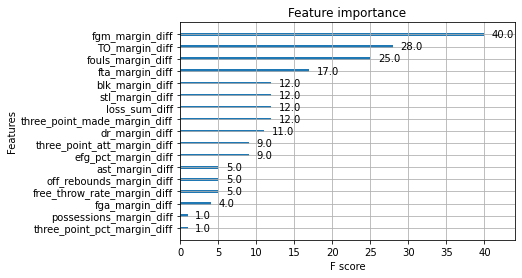

In [56]:
import xgboost as xgb
# Convert to DMatrix (XGBoost's preferred format)
train_matrix = xgb.DMatrix(predictors, label=target)

# Train the model
params = {
'alpha': 0, 'colsample_bytree': 0.8, 'eval_metric': 'logloss', 'gamma': 5, 'lambda': 0,
'learning_rate': 0.1, 'max_delta_step': 1, 'max_depth': 3, 'min_child_weight': 1,
'objective': 'binary:logistic', 'subsample': 1.0}

bst = xgb.train(params, train_matrix, num_boost_round=200)

# Plot feature importance
xgb.plot_importance(bst)
plt.show()

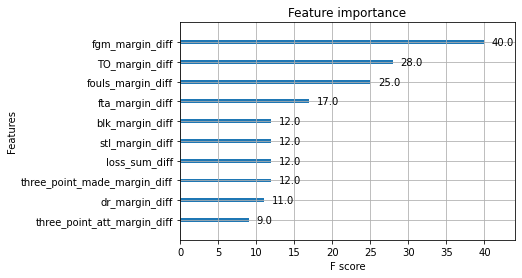

In [57]:
import matplotlib.pyplot as plt

# Assuming you have a trained XGBoost model
xgb.plot_importance(bst, importance_type='weight', max_num_features=10)
plt.show()

### Training accuracy 

In [58]:
#accuracy on train data

# Generate predictions on the training data
train_predictions = bst.predict(train_matrix)

# Apply threshold for binary classification
train_predictions_binary = (train_predictions >= 0.5).astype(int)

# Accuracy on training data
train_accuracy = (train_predictions_binary == target).mean() * 100
print(f"Training Accuracy: {train_accuracy}%")

Training Accuracy: 69.4170403587444%


### Ideas for hyperparameter tuning

In [59]:
#'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 5, 'subsample': 1.0

In [60]:
#'colsample_bytree': 0.8, 'gamma': 5, 'learning_rate': 0.2, 'max_depth': 3, 'subsample': 1.0

In [61]:
#'alpha': 0, 'booster': 'gbtree',
#'colsample_bytree': 0.8, 'eval_metric': 'logloss',
#'gamma': 0, 'lambda': 0, 'learning_rate': 0.01,
#'max_depth': 4, 'min_child_weight': 1, 'objective': 'binary:logistic',
#'subsample': 0.8, 'tree_method': 'hist'

In [62]:
#{'alpha': 0, 'booster': 'gbtree',
# 'colsample_bytree': 0.8, 'eval_metric': 'logloss',
 #'gamma': 1, 'lambda': 0, 'learning_rate': 0.01, 'max_delta_step': 0,
 #'max_depth': 5, 'min_child_weight': 1, 'objective': 'binary:logistic',
 #'subsample': 0.6, 'tree_method': 'hist'}

In [63]:
#'alpha': 0, 'booster': 'gbtree', 'colsample_bytree': 1.0,
#'eval_metric': 'logloss', 'gamma': 1, 'lambda': 0, 'learning_rate': 0.1,
#'max_delta_step': 0, 'max_depth': 5, 'min_child_weight': 1, 'objective': 'binary:logistic',
#'subsample': 1.0, 'tree_method': 'hist'

In [64]:
#'alpha': 0, 'booster': 'gbtree', 'colsample_bytree': 1.0, 'eval_metric': 'logloss',
#'gamma': 0, 'lambda': 0, 'learning_rate': 0.01, 'max_delta_step': 0, 'max_depth': 5,
#'min_child_weight': 1, 'objective': 'binary:logistic',
 #'subsample': 0.6, 'tree_method': 'hist'

In [65]:
#'alpha': 0, 'booster': 'gbtree', 'colsample_bytree': 1.0, 'eval_metric': 'logloss', 'gamma': 2, 'lambda': 0,
#'learning_rate': 0.1, 'max_delta_step': 1, 'max_depth': 5, 'min_child_weight': 1,
#'objective': 'binary:logistic', 'subsample': 1.0, 'tree_method': 'hist'

### Use 2021-2024 as the test Data
### Obtain results in terms of Accuracy, Log Loss, and AUC

In [66]:
# Define test data as all tournaments after 2020
test_data = df_model[df_model['Season'] > 2020].copy()

# Extract the label
test_target = test_data['Win'].values

# Remove the label from test data
test_predictors= test_data.drop(columns=['Win','TeamID','OpponentID','Season','OrdinalRank_diff',"seed_diff",'points_margin_diff','Point_Differential_diff',"ConfRank_diff","win_sum_diff"])

# Convert to matrix (XGBoost's preferred format)
test_m = xgb.DMatrix(test_predictors)

# Use the trained xgboost model to predict on the test matrix
predictions = bst.predict(test_m)

In [67]:
# Create a dataframe to examine our predictions vs ground truth
examine = pd.DataFrame({
    'test_target': test_target,
    'predictions': predictions
})

# Add a BinaryPred column where predictions >= 0.5 are classified as 1, else 0
examine['BinaryPred'] = np.where(examine['predictions'] >= 0.5, 1, 0)

# Simple measure of how often our model was correct
n_correct = (examine['test_target'] == examine['BinaryPred']).sum()
accuracy = n_correct / len(test_data) * 100

print(f"Accuracy: {accuracy}%")

Accuracy: 59.55056179775281%


In [68]:
from sklearn.metrics import log_loss, roc_auc_score
log_loss_value = log_loss(test_target, predictions)
print(f'Log Loss: {log_loss_value}')

auc_score = roc_auc_score(test_target, predictions)
print(f'AUC: {auc_score}')

Log Loss: 0.6660703718184102
AUC: 0.6391098205894318


### Observe some of the predictions and who played in games

In [69]:
# Add TeamID_team and OpponentID to examine (based on the same index from test_data)
examine['TeamID'] = test_data['TeamID'].values
examine['OpponentID'] = test_data['OpponentID'].values


# Merge the examine dataset with m_Teams on TeamID_team
examine = examine.merge(m_Teams[['TeamID', 'TeamName']], left_on='TeamID', right_on='TeamID', how='left')

In [70]:
# Merge again for the OpponentID using the same m_Teams dataset
examine = examine.merge(m_Teams[['TeamID', 'TeamName']], left_on='OpponentID', right_on='TeamID', how='left')

# Drop the extra 'TeamID' columns that were created from the merge
examine.drop(columns=['TeamID_y'], inplace=True)
examine.head(20)

,test_target,predictions,BinaryPred,TeamID_x,OpponentID,TeamName_x,TeamName_y
0,1,0.675833,1,1179,1455,Drake,Wichita St
1,1,0.545578,1,1313,1111,Norfolk St,Appalachian St
2,1,0.535098,1,1411,1291,TX Southern,Mt St Mary's
3,1,0.713013,1,1417,1277,UCLA,Michigan St
4,1,0.282286,0,1116,1159,Arkansas,Colgate
5,1,0.795941,1,1124,1216,Baylor,Hartford
6,1,0.394476,0,1196,1439,Florida,Virginia Tech
7,1,0.862720,1,1222,1156,Houston,Cleveland St
8,1,0.624869,1,1228,1180,Illinois,Drexel
9,1,0.792529,1,1260,1210,Loyola-Chicago,Georgia Tech


### Use ParameterGrid

Predictors and target only set to use 2003-20 data

In [71]:
from sklearn.metrics import log_loss  # Import the log_loss function from sklearn
import xgboost as xgb
from sklearn.model_selection import ParameterGrid

# Define a grid of hyperparameters
param_grid = {
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1.0],
    'colsample_bytree': [0.8, 1.0],
    'gamma': [0, 1, 5]
}

# Convert your data to DMatrix format
train_matrix = xgb.DMatrix(predictors, label=target)

# Loop through each combination of hyperparameters in the grid
best_score = float('inf')
best_auc = -float('inf')
best_params = None
for params in ParameterGrid(param_grid):
    print(f"Training with parameters: {params}")

    # Train the model with the current set of parameters
    bst = xgb.train(params, train_matrix, num_boost_round=200)

    # Evaluate the model (using log loss here, but you can use another metric)
    val_predictions = bst.predict(test_m)
    val_predictions_proba = bst.predict(test_m, output_margin=False)  # For AUC


     # Calculate log loss
    current_log_loss = log_loss(test_target, val_predictions)

    # Calculate AUC (use probabilities for AUC)
    current_auc = roc_auc_score(test_target, val_predictions_proba)

    # Track the best model by AUC or log loss
    if current_log_loss < best_score:  # If log loss is better
        best_score = current_log_loss
        best_params = params
    if current_auc > best_auc:  # If AUC is better
        best_auc = current_auc
        best_params_auc = params

print(f"Best parameters by log loss: {best_params}")
print(f"Best log loss: {best_score}")
print(f"Best parameters by AUC: {best_params_auc}")
print(f"Best AUC: {best_auc}")

Training with parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 0.8}
Training with parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 3, 'subsample': 1.0}
Training with parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'subsample': 0.8}
Training with parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 4, 'subsample': 1.0}
Training with parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'subsample': 0.8}
Training with parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.01, 'max_depth': 5, 'subsample': 1.0}
Training with parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 0.8}
Training with parameters: {'colsample_bytree': 0.8, 'gamma': 0, 'learning_rate': 0.1, 'max_depth': 3, 'subsample': 1.0}
Training with parameters: {'colsam

### Look at predictions for 2025. Simulate all possible matchups and get prediction for each

In [72]:
m_TourneySeeds2025 = m_TourneySeeds[m_TourneySeeds['Season'] == 2025]
m_TourneySeeds2025.head(3)

,Season,Seed,TeamID
2558,2025,W01,1181
2559,2025,W02,1104
2560,2025,W03,1458


In [73]:
 #To look at seed and region slots
m_TourneySlots = pd.read_csv('MNCAATourneySlots.csv')
m_TourneySlots2025 = m_TourneySlots[m_TourneySlots['Season'] == 2025]
m_TourneySlots2025.head(3)

,Season,Slot,StrongSeed,WeakSeed
2519,2025,R1W1,W01,W16
2520,2025,R1W2,W02,W15
2521,2025,R1W3,W03,W14


In [74]:
# I want to take Seed from m_TourneySeed2025 and match it with either StrongSeed or WeakSeed in m_TourneySlots
#and then join on the TeamIDs for both the StrongSeed and WeakSeed

# Merge m_TourneySeed2025 with m_TourneySlots on StrongSeed
strong_merge = pd.merge(m_TourneySlots2025, m_TourneySeeds2025, how='left', left_on='StrongSeed', right_on='Seed')
strong_merge = strong_merge.drop(columns=['Season_y', 'Seed'])
strong_merge = strong_merge.rename(columns={'TeamID': 'TeamID_Strong'})
strong_merge.head(3)

,Season_x,Slot,StrongSeed,WeakSeed,TeamID_Strong
0,2025,R1W1,W01,W16,1181.0
1,2025,R1W2,W02,W15,1104.0
2,2025,R1W3,W03,W14,1458.0


In [75]:
# Merge again with m_TourneySeed2025 on WeakSeed
first_round_matchups = pd.merge(strong_merge, m_TourneySeeds2025, how='left', left_on='WeakSeed', right_on='Seed', suffixes=('_Strong', '_Weak'))
first_round_matchups =first_round_matchups.drop(columns=['Season', 'Seed'])
first_round_matchups = first_round_matchups.rename(columns={'TeamID': 'TeamID_Weak'})
first_round_matchups.head(3)

,Season_x,Slot,StrongSeed,WeakSeed,TeamID_Strong,TeamID_Weak
0,2025,R1W1,W01,W16,1181.0,NaN
1,2025,R1W2,W02,W15,1104.0,1352.0
2,2025,R1W3,W03,W14,1458.0,1285.0


In [76]:
first_round_matchups = first_round_matchups.dropna()
first_round_matchups.head(3)

,Season_x,Slot,StrongSeed,WeakSeed,TeamID_Strong,TeamID_Weak
1,2025,R1W2,W02,W15,1104.0,1352.0
2,2025,R1W3,W03,W14,1458.0,1285.0
3,2025,R1W4,W04,W13,1112.0,1103.0


In [77]:
# Merge first_round_matchups with m_Teams on TeamID_Strong to get the TeamName for Strong
first_round_matchups = pd.merge(first_round_matchups, m_Teams[['TeamID', 'TeamName']], how='left', left_on='TeamID_Strong', right_on='TeamID')

# Rename the column for clarity
first_round_matchups = first_round_matchups.rename(columns={'TeamName': 'TeamName_Strong'})

# Merge first_round_matchups again with m_Teams on TeamID_Weak to get the TeamName for Weak
first_round_matchups = pd.merge(first_round_matchups, m_Teams[['TeamID', 'TeamName']], how='left', left_on='TeamID_Weak', right_on='TeamID')

# Rename the column for clarity
first_round_matchups = first_round_matchups.rename(columns={'TeamName': 'TeamName_Weak'})
first_round_matchups = first_round_matchups.drop(columns=['TeamID_x', 'TeamID_y'])
# Now first_round_matchups contains the team names for both TeamID_Strong and TeamID_Weak

In [78]:
first_round_matchups = first_round_matchups.rename(columns={'Season_x': 'Season'})

In [79]:
first_round_matchups = first_round_matchups.rename(columns={'TeamID_Strong': 'TeamID'})
first_round_matchups = first_round_matchups.rename(columns={'TeamID_Weak': 'OpponentID'})
first_round_matchups.head(3)

,Season,Slot,StrongSeed,WeakSeed,TeamID,OpponentID,TeamName_Strong,TeamName_Weak
0,2025,R1W2,W02,W15,1104.0,1352.0,Alabama,Robert Morris
1,2025,R1W3,W03,W14,1458.0,1285.0,Wisconsin,Montana
2,2025,R1W4,W04,W13,1112.0,1103.0,Arizona,Akron


In [80]:
# Left join with stats_team to get team stats using TeamID and Season
first_round_matchups = first_round_matchups.merge(stats_team, how='left', left_on=['TeamID', 'Season'], right_on=['TeamID', 'Season'])

# Left join with stats_opponent to get opponent stats using OpponentID and Season
first_round_matchups = first_round_matchups.merge(stats_opponent, how='left', left_on=['OpponentID', 'Season'], right_on=['TeamID', 'Season'], suffixes=('_team', '_opponent'))

first_round_matchups.head(3)

,Season,Slot,StrongSeed,WeakSeed,TeamID_team,OpponentID,TeamName_Strong,TeamName_Weak,win_sum_team,loss_sum_team,...,off_rebounds_margin_opponent,fouls_margin_opponent,fga_margin_opponent,fta_margin_opponent,fgm_margin_opponent,dr_margin_opponent,blk_margin_opponent,stl_margin_opponent,ast_margin_opponent,possessions_margin_opponent
0,2025,R1W2,W02,W15,1104.0,1352.0,Alabama,Robert Morris,25,8,...,3.090909,-2.727273,0.909091,5.242424,0.787879,2.151515,0.909091,-0.666667,2.878788,-0.511515
1,2025,R1W3,W03,W14,1458.0,1285.0,Wisconsin,Montana,26,9,...,-2.612903,-1.193548,-4.322581,0.967742,-0.225806,-0.258065,0.161290,0.483871,0.903226,-1.703226
2,2025,R1W4,W04,W13,1112.0,1103.0,Arizona,Akron,22,12,...,1.125000,1.468750,2.750000,-3.500000,3.531250,3.250000,1.281250,0.375000,5.750000,-0.165000


In [81]:
first_round_matchups['ConfRank_team'] = first_round_matchups['ConfRank_team'].astype(int)
first_round_matchups['ConfRank_opponent'] = first_round_matchups['ConfRank_opponent'].astype(int)

In [82]:
first_round_matchups['three_point_pct_margin_diff'] = first_round_matchups['three_point_pct_margin_team'] - first_round_matchups['three_point_pct_margin_opponent']
first_round_matchups['efg_pct_margin_diff'] = first_round_matchups['efg_pct_margin_team'] - first_round_matchups['efg_pct_margin_opponent']
first_round_matchups['free_throw_rate_margin_diff'] = first_round_matchups['free_throw_rate_margin_team'] - first_round_matchups['free_throw_rate_margin_opponent']
first_round_matchups['three_point_att_margin_diff'] = first_round_matchups['three_point_att_margin_team'] - first_round_matchups['three_point_att_margin_opponent']
first_round_matchups['three_point_made_margin_diff'] = first_round_matchups['three_point_made_margin_team'] - first_round_matchups['three_point_made_margin_opponent']
first_round_matchups['points_margin_diff'] = first_round_matchups['points_margin_team'] - first_round_matchups['points_margin_opponent']
first_round_matchups['TO_margin_diff'] = first_round_matchups['TO_margin_team'] - first_round_matchups['TO_margin_opponent']
first_round_matchups['off_rebounds_margin_diff'] = first_round_matchups['off_rebounds_margin_team'] - first_round_matchups['off_rebounds_margin_opponent']
first_round_matchups['fouls_margin_diff'] = first_round_matchups['fouls_margin_team'] - first_round_matchups['fouls_margin_opponent']
first_round_matchups['fga_margin_diff'] = first_round_matchups['fga_margin_team'] - first_round_matchups['fga_margin_opponent']
first_round_matchups['fta_margin_diff'] = first_round_matchups['fta_margin_team'] - first_round_matchups['fta_margin_opponent']
first_round_matchups['fgm_margin_diff'] = first_round_matchups['fgm_margin_team'] - first_round_matchups['fgm_margin_opponent']
first_round_matchups['Point_Differential_diff'] = first_round_matchups['Point Differential_avg_team'] - first_round_matchups['Point Differential_avg_opponent']
first_round_matchups['ConfRank_diff'] = first_round_matchups['ConfRank_team'] - first_round_matchups['ConfRank_opponent']
first_round_matchups['seed_diff'] = first_round_matchups['Seed_opponent'] - first_round_matchups['Seed_team']
first_round_matchups['win_sum_diff'] = first_round_matchups['win_sum_team'] - first_round_matchups['win_sum_opponent']
first_round_matchups['loss_sum_diff'] = first_round_matchups['loss_sum_team'] - first_round_matchups['loss_sum_opponent']
first_round_matchups['stl_margin_diff'] = first_round_matchups['stl_margin_team'] - first_round_matchups['stl_margin_opponent']
first_round_matchups['blk_margin_diff'] = first_round_matchups['blk_margin_team'] - first_round_matchups['blk_margin_opponent']
first_round_matchups['ast_margin_diff'] = first_round_matchups['ast_margin_team'] - first_round_matchups['ast_margin_opponent']
first_round_matchups['dr_margin_diff'] = first_round_matchups['dr_margin_team'] - first_round_matchups['dr_margin_opponent']
first_round_matchups['possessions_margin_diff'] = first_round_matchups['possessions_margin_team'] - first_round_matchups['possessions_margin_opponent']

In [83]:
#first_round_matchups['ConfRank_opponent'] = first_round_matchups['ConfRank_opponent'].astype(int)
#first_round_matchups['ConfRank_team'] = first_round_matchups['ConfRank_team'].astype(int)
first_round_predictors = first_round_matchups[selected]

# Convert to matrix (XGBoost's preferred format)
first_round_test = xgb.DMatrix(first_round_predictors)

# Use the trained xgboost model to predict on the test matrix
predictions = bst.predict(first_round_test)

In [84]:
# Create a dataframe to examine our predictions vs ground truth
examine = pd.DataFrame({
    'predictions': predictions
})

# Add a BinaryPred column where predictions >= 0.5 are classified as 1, else 0
examine['BinaryPred'] = np.where(examine['predictions'] >= 0.5, 1, 0)
examine.head(3)

,predictions,BinaryPred
0,0.554560,1
1,0.634252,1
2,0.533669,1


In [85]:
# Add TeamID_team and OpponentID to examine (based on the same index from test_data)
examine['TeamID'] = first_round_matchups['TeamID_team'].values
examine['OpponentID'] = first_round_matchups['OpponentID'].values


# Merge the examine dataset with m_Teams on TeamID_team
examine = examine.merge(m_Teams[['TeamID', 'TeamName']], left_on='TeamID', right_on='TeamID', how='left')
examine.head(5)

,predictions,BinaryPred,TeamID,OpponentID,TeamName
0,0.554560,1,1104.0,1352.0,Alabama
1,0.634252,1,1458.0,1285.0,Wisconsin
2,0.533669,1,1112.0,1103.0,Arizona
3,0.367909,0,1332.0,1251.0,Oregon
4,0.452753,0,1140.0,1433.0,BYU


In [86]:
# Merge again to get the Opponent TeamName
examine = examine.merge(m_Teams[['TeamID', 'TeamName']], left_on='OpponentID', right_on='TeamID', how='left', suffixes=('', '_Opponent'))
examine = examine.drop(columns=['TeamID_Opponent'])

In [87]:
examine.tail(30)

,predictions,BinaryPred,TeamID,OpponentID,TeamName,TeamName_Opponent
2,0.533669,1,1112.0,1103.0,Arizona,Akron
3,0.367909,0,1332.0,1251.0,Oregon,Liberty
4,0.452753,0,1140.0,1433.0,BYU,VCU
5,0.702344,1,1388.0,1435.0,St Mary's CA,Vanderbilt
6,0.528350,1,1280.0,1124.0,Mississippi St,Baylor
7,0.703834,1,1222.0,1188.0,Houston,SIUE
8,0.702344,1,1397.0,1459.0,Tennessee,Wofford
9,0.508835,1,1246.0,1407.0,Kentucky,Troy
10,0.410730,0,1345.0,1219.0,Purdue,High Point
11,0.449485,0,1155.0,1270.0,Clemson,McNeese St


## More methods to improve / find better model

### Find best predictors using RFE

In [88]:
from sklearn.feature_selection import RFE
from xgboost import XGBClassifier

# Initialize XGBoost classifier
model = XGBClassifier()

# Use RFE to select features
rfe = RFE(model, n_features_to_select=30)  # Change to select top 30 features
fit = rfe.fit(predictors, target)

# Get the selected features
selected_features = [f for f, s in zip(predictors.columns, fit.support_) if s]
print("Selected Features:", selected_features)

Selected Features: ['three_point_pct_margin_diff', 'efg_pct_margin_diff', 'free_throw_rate_margin_diff', 'three_point_att_margin_diff', 'three_point_made_margin_diff', 'TO_margin_diff', 'off_rebounds_margin_diff', 'fouls_margin_diff', 'fga_margin_diff', 'fta_margin_diff', 'fgm_margin_diff', 'loss_sum_diff', 'stl_margin_diff', 'blk_margin_diff', 'ast_margin_diff', 'dr_margin_diff', 'possessions_margin_diff']


/Users/logan/opt/anaconda3/lib/python3.9/site-packages/sklearn/feature_selection/_rfe.py:300: UserWarning: Found n_features_to_select=30 > n_features=17. There will be no feature selection and all features will be kept.
  warnings.warn(


### H20 to find best model

In [89]:
!pip install h2o

In [90]:
import h2o
from h2o.automl import H2OAutoML
from h2o import H2OFrame
import pandas as pd

# Initialize H2O cluster
h2o.init()

# Filter for training data (2003 to 2019)
train_data = df[(df['Season'] >= 2003) & (df['Season'] < 2020)]

# Extract the label and features
target = 'Win'
train_X = train_data.drop(columns=['Win','TeamID','OpponentID','Season','OrdinalRank_diff',"seed_diff",'points_margin_diff','Point_Differential_diff',"ConfRank_diff","win_sum_diff"])

# Define test data as all tournaments after 2020
test_data = df[df['Season'] > 2020].copy()

# Extract the label for test data
test_target = 'Win'
test_X = test_data.drop(columns=['Win','TeamID','OpponentID','Season','OrdinalRank_diff',"seed_diff",'points_margin_diff','Point_Differential_diff',"ConfRank_diff","win_sum_diff"])

# Convert to H2OFrame
train_h2o = H2OFrame(train_data)
test_h2o = H2OFrame(test_data)

# Convert target column to categorical for classification
train_h2o[target] = train_h2o[target].asfactor()
test_h2o[target] = test_h2o[target].asfactor()

# Initialize H2O AutoML
aml = H2OAutoML(max_models=10, seed=42, nfolds=0)  # Setting nfolds=0 to avoid cross-validation

# Train the AutoML model
aml.train(y=target, training_frame=train_h2o)

# View leaderboard of best models
print(aml.leaderboard)

# Get the best model
best_model = aml.leader

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "1.8.0_402"; OpenJDK Runtime Environment Corretto-8.402.08.1 (build 1.8.0_402-b08); OpenJDK 64-Bit Server VM Corretto-8.402.08.1 (build 25.402-b08, mixed mode)
  Starting server from /Users/logan/opt/anaconda3/lib/python3.9/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/1f/pzcwbqq976x0rg8fkqzpx0rc0000gn/T/tmpir8l42w2
  JVM stdout: /var/folders/1f/pzcwbqq976x0rg8fkqzpx0rc0000gn/T/tmpir8l42w2/h2o_logan_started_from_python.out
  JVM stderr: /var/folders/1f/pzcwbqq976x0rg8fkqzpx0rc0000gn/T/tmpir8l42w2/h2o_logan_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


H2O_cluster_uptime:,02 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.7
H2O_cluster_version_age:,2 months and 23 days
H2O_cluster_name:,H2O_from_python_logan_qfw2wp
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,1.770 Gb
H2O_cluster_total_cores:,8
H2O_cluster_allowed_cores:,8
H2O_cluster_status:,"locked, healthy"


Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
Parse progress: |████████████████████████████████████████████████████████████████| (done) 100%
AutoML progress: |
15:03:06.100: AutoML: XGBoost is not available; skipping it.

███████████████████████████████████████████████████████████████| (done) 100%
model_id                                          auc    logloss     aucpr    mean_per_class_error      rmse       mse
GLM_1_AutoML_1_20250620_150306               0.784018   0.555313  0.768631                0.294864  0.434295  0.188612
XRT_1_AutoML_1_20250620_150306               0.767127   0.570313  0.754509                0.304296  0.441481  0.194905
DRF_1_AutoML_1_20250620_150306               0.761296   0.715843  0.752225                0.318143  0.444604  0.197673
GBM_5_AutoML_1_20250620_150306               0.753151   0.599289  0.724973                0.326888  0.453373  0.205547
GBM_1_AutoML_1_20250620_150306               0.75015    0

In [91]:
# Generate predictions
preds = best_model.predict(test_h2o)

# Convert to pandas DataFrame for easier handling
preds_df = preds.as_data_frame()

# Attach predictions to test data
results = test_data.copy()
results['prediction'] = preds_df['predict']  # 0 or 1 predicted class
results['prob_win'] = preds_df['p1']         # probability team 1 wins
results['prob_loss'] = preds_df['p0']        # probability team 1 loses

# Look at top results
results.head()

glm prediction progress: |███████████████████████████████████████████████████████| (done) 100%


/Users/logan/opt/anaconda3/lib/python3.9/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install polars and pyarrow and use it as pandas_df = h2o_df.as_data_frame(use_multi_thread=True)

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


,Season,TeamID,OpponentID,Win,win_sum_team,loss_sum_team,Seed_team,games_played_team,OrdinalRank_team,Point Differential_avg_team,...,win_sum_diff,loss_sum_diff,stl_margin_diff,blk_margin_diff,ast_margin_diff,dr_margin_diff,possessions_margin_diff,prediction,prob_win,prob_loss
1115,2021,1179,1455,1,23,4,11.0,27,64.0,11.185185,...,9,-1,1.038986,-0.727096,2.323587,3.929825,-1.151501,NaN,NaN,NaN
1116,2021,1313,1111,1,14,7,16.0,21,239.0,4.571429,...,1,-4,-0.708333,0.803571,1.005952,3.184524,1.234524,NaN,NaN,NaN
1117,2021,1411,1291,1,15,8,16.0,23,234.0,3.478261,...,3,-2,2.972332,-0.142292,-2.401186,0.490119,1.330751,NaN,NaN,NaN
1118,2021,1417,1277,1,17,9,11.0,26,38.0,4.346154,...,2,-3,2.074074,-1.707977,-1.131054,0.952991,0.398006,NaN,NaN,NaN
1119,2021,1116,1159,1,22,6,3.0,28,26.0,11.714286,...,8,5,-1.047619,0.900000,-3.359524,-3.497619,1.114476,NaN,NaN,NaN


In [92]:
train_perf = best_model.model_performance(train_h2o)
train_accuracy = train_perf.accuracy()[0][1]  # Get accuracy at default threshold
print(f"Training Accuracy: {train_accuracy:.4f}")

Training Accuracy: 0.7148


In [93]:
test_perf = best_model.model_performance(test_h2o)
test_accuracy = test_perf.accuracy()[0][1]  # Get accuracy at default threshold
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.6891


### Notes 

In [94]:
#predictors/outcomes

#Load in Battorvik AwayNuetral and Home and see if I can make subset (PREDICTOR)

#Load in tournament Mathcup to get seeding as well (PREDICTOR)

#Use EvanMiya to get pace of play (PREDICTOR)

#Heat rankings for round they made it to (OUTCOME)

#Resumes for possible additional stats (PREDICTOR)


#ideas

# I loaded in Data sets from Kaggle in order to make predictions for this upcoming matchups in 2025. I have data from 2008-24.
# Using the 15 tournmanets in that time frame, I will use key statistics to determine what round a team makes it to based on their stats.
# Though If I want an output like 1,2,3,4,5,6 where (1 is only round of 64, 2 is round of 32, 3 is sweet 16... etc)
# The one issue i come across is that I need 32 teams selected to make the round of 32 for example, but the model could give the value 2 for more/less than that amount


#So... actually in this case it would most likely be predicting the number of "wins" team gets by saying 0-6 wins
# For example based on historical data a team could have won anywehre between 0-6 games
# Based on these stats, this year, Uconn is projected to get 1.23 wins. I would compare this as a rating to all the other teams and higher it is the better the team is
# Ridge or Lasso Regression,Random Forest Regressor, XGBoost or LightGBM
#Mean Squared Error (MSE), (MAE) or R-Squared. to evaluate


# USE Game information and final result to be able to take the matchups for this years march madness and make a prediction on who should win.
#Calculate differences in key statistics (Team A stat - Team B stat) to capture strength comparison.
#Binary outcome
#Logistic Regression, Random Forest, or XGBoost
#Accuary, F1score, AUC, Confusion Matrix to evaluate

In [95]:
### opponent strength
### tournament history
### coaching
### interaction terms like Point_Differential_diff * ConfRank_diff , efg_pct_margin_diff * TO_margin_diff

### Penalize overconfidence:
#Use a custom loss function that rewards underdog wins.